# Analysis of Argo data South of 60S

## By Nick Young and Fabio Viera Machado

In [1]:
from netCDF4 import Dataset, num2date
import glob
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe
from scipy import interpolate
from tqdm import tqdm_notebook as tqdm
import oceansdb
#import seawater as sw
#from seawater.library import T90conv

In [2]:
def load_netcdf(path = "Argo_South_60"):
    # load_netcdf function input: path - default is "Argo_South_60"
    files = glob.glob("data/" + path + "/**/*.nc", recursive=True)
    # glob.glob - returns a list of all the files in a given folder with the extension 'nc'
    # recursive=true - keeps on looking for all the files till the end, or the last file that exist
    
    # creating lists
    lats = []
    lons = []
    datetimes = []
    sst = []
    max_depth = []
#    temp_profiles = []

    for f in tqdm(files):
        # tqdm - make your loops show a progress meter
        d = Dataset(f)
        # DATASET - Creating/Opening/Closing a netCDF file. 
        #This is the method used to open an existing netCDF file.
        lat = d.variables["LATITUDE"][:]
        mask = lat < -60
        lon = d.variables["LONGITUDE"][:]
      #  temp_profile = d.variables["TEMP_ADJUSTED"][:]
      #  ##  initializing matrices 
      #  temp_profiles = np.array([temp_prof]) 
      #  array1 = np.array([1,2,3])
      #  array2 = np.array([4,5,6])
      #  matrix1 = np.array([array1,array2])
      #  matrix1
        lats.extend(lat[mask])
        lons.extend(lon[mask])
        #1 The extend () method adds the specified list elements to the end of the current list.
        #2 This method does not return any value but add the content to existing list.
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        #1 getncattr - reads the attributes of given variable i.e units
        dates = num2date(juld, units, "standard")
        #1 num2date - converts the format of the loaded datetime to standard format YYYY-MM-dd
        datetimes.extend(dates[mask])
        try:
            sst.extend(d.variables["TEMP_ADJUSTED"][mask,0])
            #1 checks if sst is below 60S and if so, adds it
        except:
            sst.extend(np.full(len(mask), np.nan))
            #2 if sst is above 60S, adds nan values
        max_depth.extend(np.nanmax(d.variables["PRES_ADJUSTED"], axis=1))
        
    #1 array() - allows one to do operations on a list
    #2 NumPy was imported as np
    #3 If we want to do math on a homogeneous array of numeric data, then it is much better to use NumPy, 
    #  which can automatically vectorize operations on complex multi-dimensional arrays
    lats = np.array(lats)
    lons = np.array(lons)
    datetimes = np.array(datetimes)
    sst = np.array(sst)
    # saving the arrays in files
    np.save(path + "_lats", lats)
    np.save(path + "_lons", lons)
    np.save(path + "_dts", datetimes)
    np.save(path + "_sst", sst)
    np.save(path + "_depth", max_depth)
    return lats, lons, datetimes, sst, max_depth

def plot(lats, lons, z = [], title = "Argo profiles south of 60S", cbtitle = "Number of points in bin", vmax=None):
    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, 0, 20))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    plt.title("{} {}".format(len(lats), title))

    x, y = m(lons, lats)
    if len(z) == 0:
        hh, locx, locy = np.histogram2d(x, y, bins=100)
        # Sort the points by density, so that the densest points are plotted last
        z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
        #print(describe(z))
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    #m.imshow(heatmap, interpolation='bicubic', cmap="jet")
    m.scatter(x, y, c=z, s=5, alpha=1, cmap="jet", vmax=vmax)
    cb = plt.colorbar()
    cb.set_label(cbtitle, rotation=270)
    plt.show()

def plot_time(dts, title, label):
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    for i, dt in enumerate(dts):
    #1 enumerate() method adds a counter to an iterable and returns it in a form of enumerate object.
    #  This enumerate object can then be used directly in for loops or be converted into a list of tuples using list() method.
        k = label[i]
        df = pd.DataFrame({k: dt})
        #1 Pandas was imported as pd
        #2 Dataframe class - class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
        #  Two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows and columns).
        #  Arithmetic operations align on both row and column labels. 
        #  Can be thought of as a dict-like container for Series objects
        df = df.groupby(by=df[k].dt.date).count()
        #1 groupby - groups data by a certain specified variable type
        df.plot(ax=ax, style='.', markersize=3)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.set_title(title, fontsize=18)
        ax.set_xlabel("Time",fontsize=14)
        ax.set_ylabel("Number of profiles",fontsize=14)
        #ax.set_xlabel("")
        ax.legend(fontsize=14)
    plt.show()

In [75]:
argo_lats, argo_lons, argo_dts, argo_sst, argo_depth = load_netcdf()
#plot(argo_lats, argo_lons, vmax=100)
#plot(argo_lats, argo_lons, argo_sst[:len(argo_lats)], title = "Argo SST", cbtitle = "Temperature °C")
#plot(argo_lats, argo_lons, argo_depth[:len(argo_lats)], title = "Argo Depth", cbtitle = "Depth (decibar pressure)")
print(min(argo_sst),max(argo_sst))

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.


-1.9769999980926514 7.535999774932861


In [ ]:
print(min(argo_dts), max(argo_dts))
plot_time([argo_dts], "Argo float dailystamps", ["Argo"])

In [77]:
seal_lats, seal_lons, seal_dts, seal_sst, seal_depth = load_netcdf("seal")
#print(seal_lats.shape, seal_sst.shape, argo_lats.shape, argo_sst.shape)
#print(min(seal_sst),max(seal_sst))
plot(seal_lats, seal_lons, title = "Seal data south of 60S", vmax=100)
plot(seal_lats, seal_lons, seal_sst[:len(seal_lats)], title = "Seal SST", cbtitle = "Temperature °C")
plot(seal_lats, seal_lons, seal_depth[:len(seal_lats)], title = "Seal Depth", cbtitle = "Depth (decibar pressure)")

-2.0 6.125


In [ ]:
print(min(seal_dts), max(seal_dts))
plot_time([seal_dts], "Seal data dailystamps", ["Elephant seal"])

In [5]:
all_lats = np.concatenate((seal_lats, argo_lats))
all_lons = np.concatenate((seal_lons, argo_lons))
plot(all_lats, all_lons, title="Argo + seal data south of 60S", vmax=100)

In [ ]:
plot_time([seal_dts, argo_dts], "Argo + seal data dailystamps", ["Seal", "Argo"])

In [78]:
def load_netcdf_grid(path = "Argo_South_60", resolution = 1, target_var = "temp", with_depth = False, filter_month = None, filter_season = None):
    if with_depth:
        grid = np.full(shape=[15 * resolution, 360 * resolution, 200], fill_value=np.nan)
    else:
        grid = np.full(shape=[15 * resolution, 360 * resolution], fill_value=np.nan)
    files = glob.glob("data/{}/**/*.nc".format(path), recursive=True)
    #1 glob.glob - returns a list of all the files in a given folder with the extension 'nc'
    #2 recursive=true - keeps on looking for all the files till the end, or the last file that exist
             
    for f in tqdm(files[:]):
    # tqdm - make your loops show a progress meter
        d = Dataset(f)
        #1 DATASET - Creating/Opening/Closing a netCDF file. 
        # This is the method used to open an existing netCDF file.
        lat = d.variables["LATITUDE"][:]
        mask = (lat < -60) & (lat > -74.5)
        if filter_month:
            juld = d.variables["JULD"][:]
            units = d.variables["JULD"].getncattr('units')
            dates = num2date(juld, units, "standard")
            datemask = np.array([d.month == filter_month for d in dates])
            mask &= datemask
        if filter_season:
            juld = d.variables["JULD"][:]
            units = d.variables["JULD"].getncattr('units')
            dates = num2date(juld, units, "standard")
            if filter_season == "Summer":
                datemask = np.array([d.month >= 10 or d.month <= 3 for d in dates])
            elif filter_season == "Winter":
                datemask = np.array([d.month > 3 and d.month < 10 for d in dates])
            mask &= datemask
        if any(mask):
            lat = np.round((np.abs(lat[mask]) - 60) * resolution).astype(int)
            lon = d.variables["LONGITUDE"][mask]
            lon = np.round((lon + 180) * resolution).astype(int)
            lon[lon == 360 * resolution] = 0
            if with_depth:
                #pres = np.round(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                pres = np.floor(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                temp = d.variables["TEMP_ADJUSTED"][mask]
                if target_var == "sal":
                    try:
                        sal = d.variables["PSAL_ADJUSTED"][mask]
                    except:
                        print("No salinity for {}".format(f))
                        continue
            else:
                pres = d.variables["PRES_ADJUSTED"][mask]
                temp = d.variables["TEMP_ADJUSTED"][mask, 0]
            for x in np.unique(lon):
                for y in np.unique(lat):
                    if with_depth:
                        ptmask = (lon == x) & (lat == y)
                        for z in np.unique(pres[ptmask]):
                            if z>= 200 or np.ma.is_masked(z):
                                continue
                            depthmask = pres[ptmask] == z
                            if target_var == "temp":
                                mean_for_pt = np.ma.mean(temp[ptmask][depthmask])
                            elif target_var == "sal":
                                mean_for_pt = np.ma.mean(sal[ptmask][depthmask])
                            if not np.isnan(mean_for_pt) and not np.ma.is_masked(mean_for_pt):
                                grid[y, x, z] = np.nanmean((grid[y, x, z], mean_for_pt))
                    else:
                        ptmask = (lon == x) & (lat == y)
                        if target_var == "n_point":
                            v = np.sum(ptmask)
                            if not np.ma.is_masked(v):
                                if v != 0:                                   
                                #1 added a if statement checking if number of points is greater than 0
                                    grid[y, x] = np.nansum((grid[y, x], v))
                        elif target_var == "temp":
                            temps_at_pt = temp[ptmask]
                            v = np.ma.mean(temps_at_pt)
                            if not np.ma.is_masked(v):
                                grid[y, x] = np.nanmean((grid[y, x], v))
                        elif target_var == "depth":
                            pres_at_pt = pres[ptmask]
                            if len(pres_at_pt):
                                v = np.ma.max(pres[ptmask])
                                if not np.ma.is_masked(v):
                                    grid[y, x] = np.nanmax((grid[y, x], v))
    return grid

def plot_grid(grid, resolution = 1, title="Argo data\n0-10 decibars mean temperature", cbtitle="Temperature °C", vmin=None, vmax=None):
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, 0, 20))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    plt.title("\n{} at {}° resolution".format(title, 1/resolution),fontsize = 16)

    x = np.arange(-180, 180.1, 1/resolution)
    y = np.arange(-60, -75.1, 1/-resolution)
    x, y = np.meshgrid(x, y)
    x, y = m(x, y)

    m.pcolormesh(x, y, grid, cmap="jet", vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.set_label(cbtitle, rotation=270, fontsize = 12)
    plt.show()
    
def interp_nans(grid, method='linear'):
    x = np.arange(0, grid.shape[1])
    y = np.arange(0, grid.shape[0])
    mask = np.isnan(grid)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~mask]
    y1 = yy[~mask]
    newarr = grid[~mask]
    interp = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method=method)
    if method == "linear":
        interp = interp_nans(interp, "nearest")
    return interp

In [79]:
# Titles and labels for figures
a_title = " Argo Data "
s_title = " Seal Data "
comb_title = " Argo+Seal Data "
interp_title = " Interpolated Argo+Seal Data "
msf = " Mean Salinity "
mtf = " Mean Temperature "
msd = " Mean Density"
T_title = " Temperature "
S_title = " Salinity "
D_title = " Density "

# Maximum and Minimum - temperature and Salinity
smax = 34.8
smin = 32.5
tmax = 6
tmin = -3
rhomin = 1028
rhomax = 1026.5
# Grid Resolution
resolution = 2

In [9]:
argo_pt_grid = load_netcdf_grid(target_var="n_point", with_depth = False, resolution = resolution)
seal_pt_grid = load_netcdf_grid(path="seal", target_var="n_point", with_depth = False, resolution = resolution)

In [10]:
combined_pt_grid = np.nansum((argo_pt_grid, seal_pt_grid), axis=0)
combined_pt_grid[np.isnan(argo_pt_grid) & np.isnan(seal_pt_grid)] = np.nan
print(argo_pt_grid.shape,seal_pt_grid.shape,combined_pt_grid.shape)

(30, 720) (30, 720) (30, 720)


In [ ]:
plot_grid(argo_pt_grid, title=a_title + "\nNumber of vertical profiles", cbtitle="Number of profiles", vmin=1,vmax=25, resolution = resolution)
plot_grid(seal_pt_grid, title=s_title + "\nNumber of vertical profiles", cbtitle="Number of profiles", vmin=1,vmax=25, resolution = resolution)
plot_grid(combined_pt_grid, title=comb_title + "\nNumber of vertical profiles", cbtitle="Number of profiles", vmin=1,vmax=25, resolution = resolution)

In [13]:
argo_temp_grid = load_netcdf_grid(resolution = resolution)
seal_temp_grid = load_netcdf_grid("seal", resolution = resolution)
#print(argo_temp_grid.shape,seal_temp_grid.shape)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\numpy\ma\core.py:5159: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice



(30, 720) (30, 720)


In [14]:
combined_temp_grid = np.nanmean((argo_temp_grid, seal_temp_grid), axis=0)
#print(combined_temp_grid.shape)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(30, 720)


c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


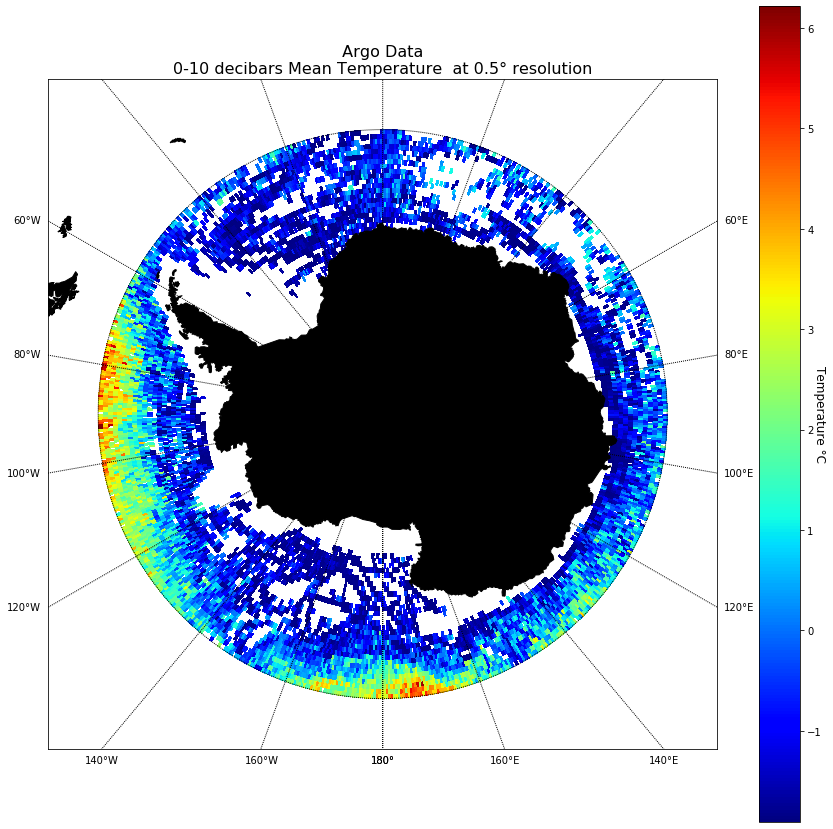

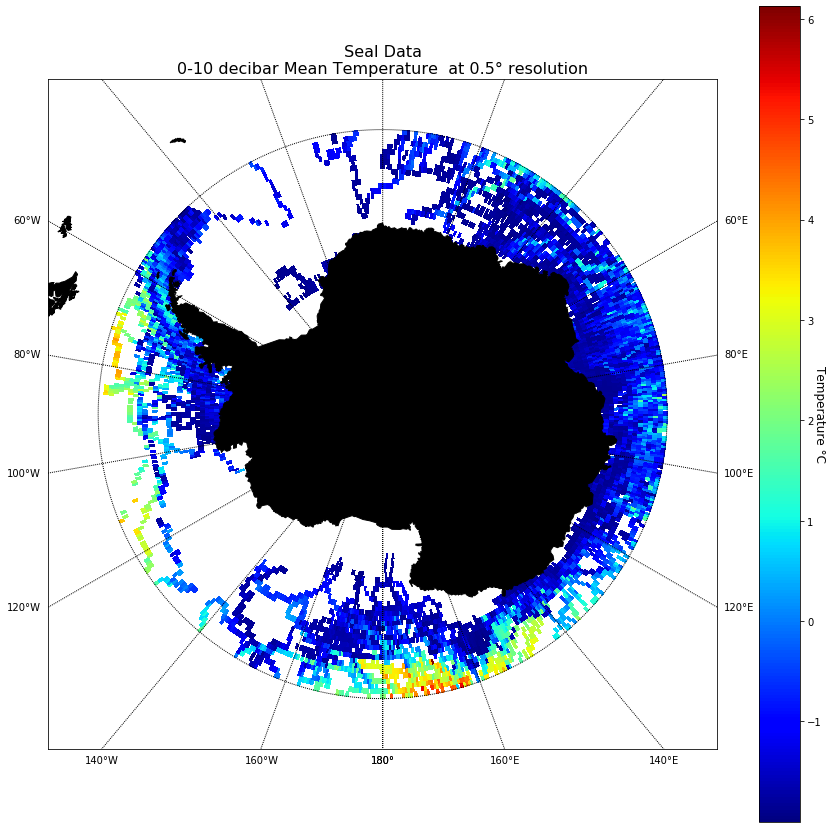

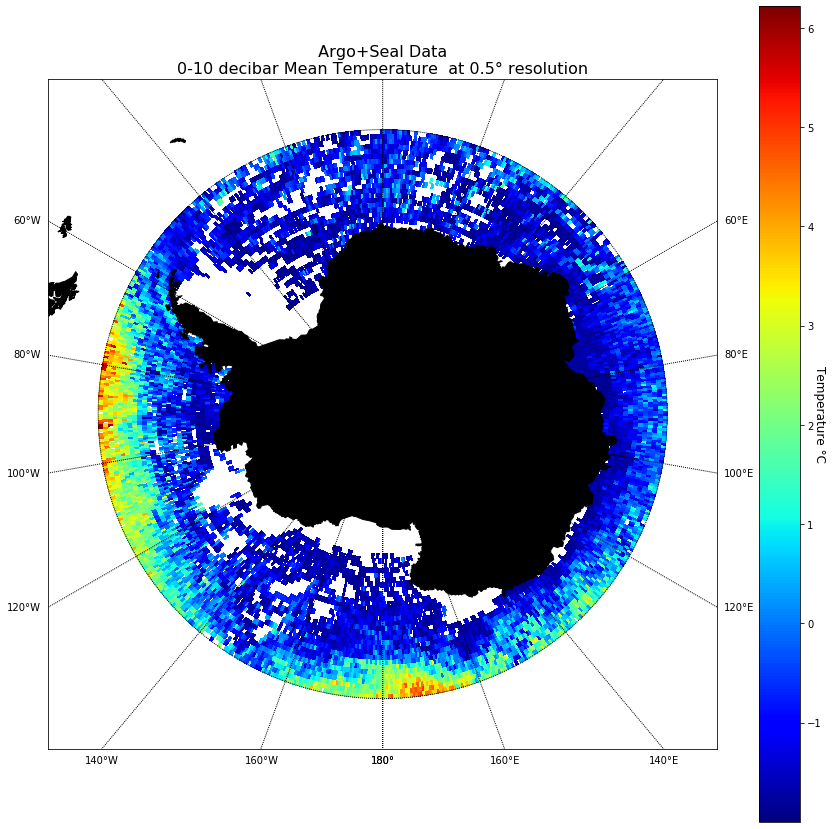

In [82]:
#title = "Seal data gridded at {}\n0-10 decibar mean temperature\nMean across all points = {}".format(1/resolution,sealmean)
title = a_title + "\n0-10 decibars" + mtf
plot_grid(argo_temp_grid, title=title, resolution = resolution)
title = s_title + "\n0-10 decibar" + mtf
plot_grid(seal_temp_grid, title=title, resolution = resolution)
title = comb_title + "\n0-10 decibar" + mtf
plot_grid(combined_temp_grid, title=title, resolution = resolution)

In [15]:
interp = interp_nans(combined_temp_grid)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


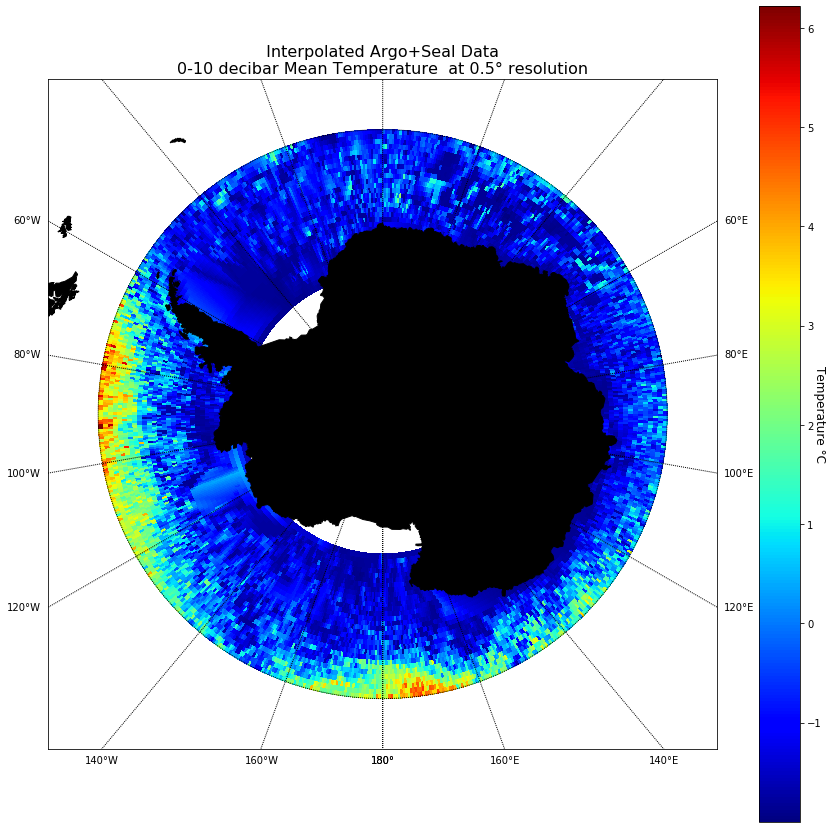

In [83]:
#title = "Argo+Seal data gridded at {}\n0-10 decibar mean temperature\nMean across all points = {}".format(1/resolution,interpmean)
title = interp_title + "\n0-10 decibar" + mtf
plot_grid(interp, resolution = resolution, title=title)

In [16]:
argo_max_depth = load_netcdf_grid(target_var = "depth", resolution = resolution)
seal_max_depth = load_netcdf_grid("seal", target_var = "depth", resolution = resolution)

(30, 720) (30, 720)


c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


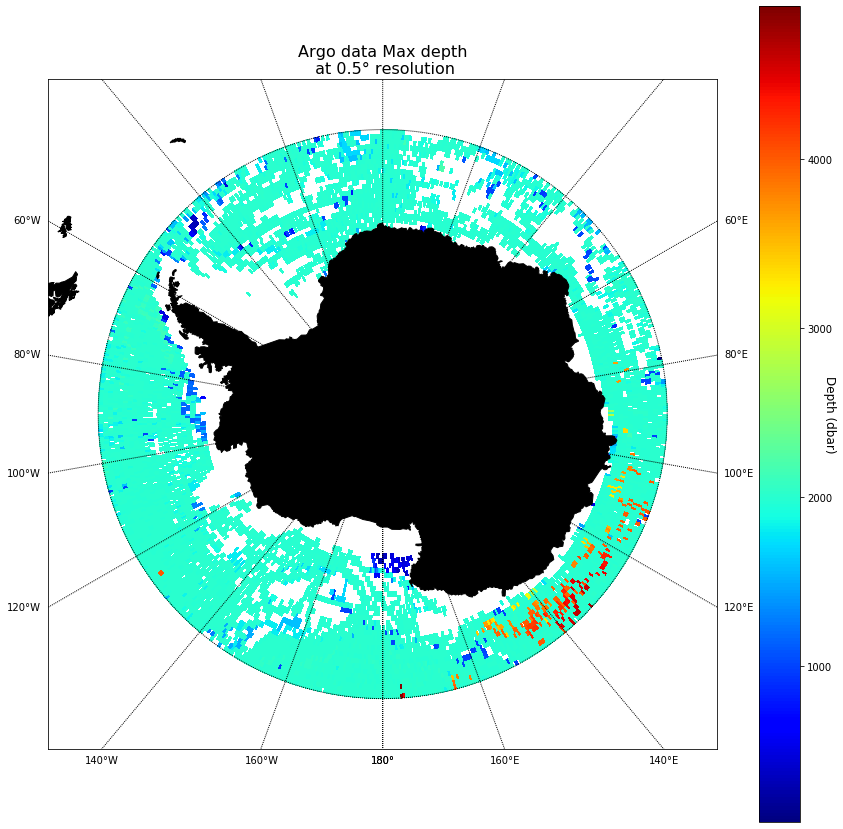

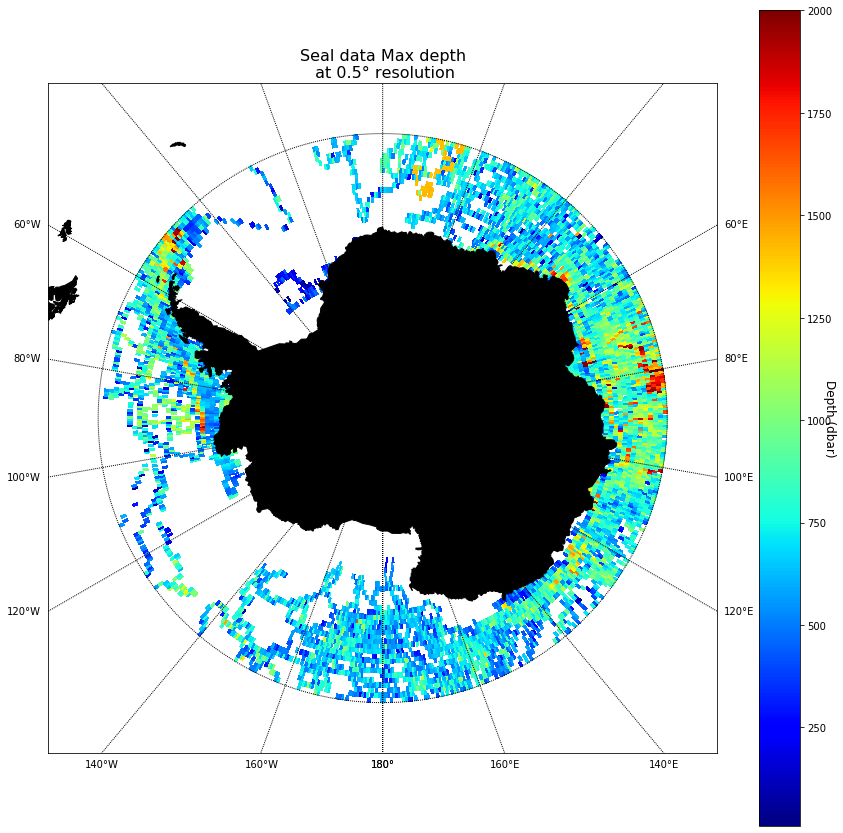

In [86]:
#print(argo_max_depth.shape,seal_max_depth.shape)
plot_grid(argo_max_depth, resolution = resolution, title="Argo data Max depth\n", cbtitle="Depth (dbar)")
plot_grid(seal_max_depth, resolution = resolution, title="Seal data Max depth\n", cbtitle="Depth (dbar)", vmax=2000)

In [ ]:
# Monthly temperature field
for month in range(1, 13):
    argo_temp = load_netcdf_grid(filter_month = month, with_depth=True)
    seal_temp = load_netcdf_grid("seal", filter_month = month, with_depth=True)
    combined_temp = np.nanmean((argo_temp, seal_temp), axis=0)
    np.save("argo_temp_grid_{}".format(month), argo_temp)
    np.save("seal_temp_grid_{}".format(month), seal_temp)
    np.save("combined_temp_grid_{}".format(month), combined_temp)
    interp_temp = interp_nans(combined_temp[:,:,0])
    argomean = np.round(np.nanmean(argo_temp), 2)
    sealmean = np.round(np.nanmean(seal_temp), 2)
    combmean = np.round(np.nanmean(combined_temp), 2)
    interpmean = np.round(np.nanmean(interp_temp), 2)
#   #title = a_title + "\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    title = a_title + "\n0-10 decibars mean temperature for {}".format(calendar.month_abbr[month])
    plot_grid(argo_temp[:,:,0], title=title)
#   #title = "Seal data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], sealmean)
    title = s_title + "\n0-10 decibar mean temperature for {}".format(calendar.month_abbr[month])
    plot_grid(seal_temp[:,:,0], title=title)
    title = comb_title + "\n0-10 decibar mean temperature for {}".format(calendar.month_abbr[month])
#   title = "Argo+Seal data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], combmean)
    plot_grid(combined_temp[:,:,0], title=title)
    title = interp_title + "\n0-10 decibar mean for {}".format(calendar.month_abbr[month])
    plot_grid(interp_temp, title=title)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


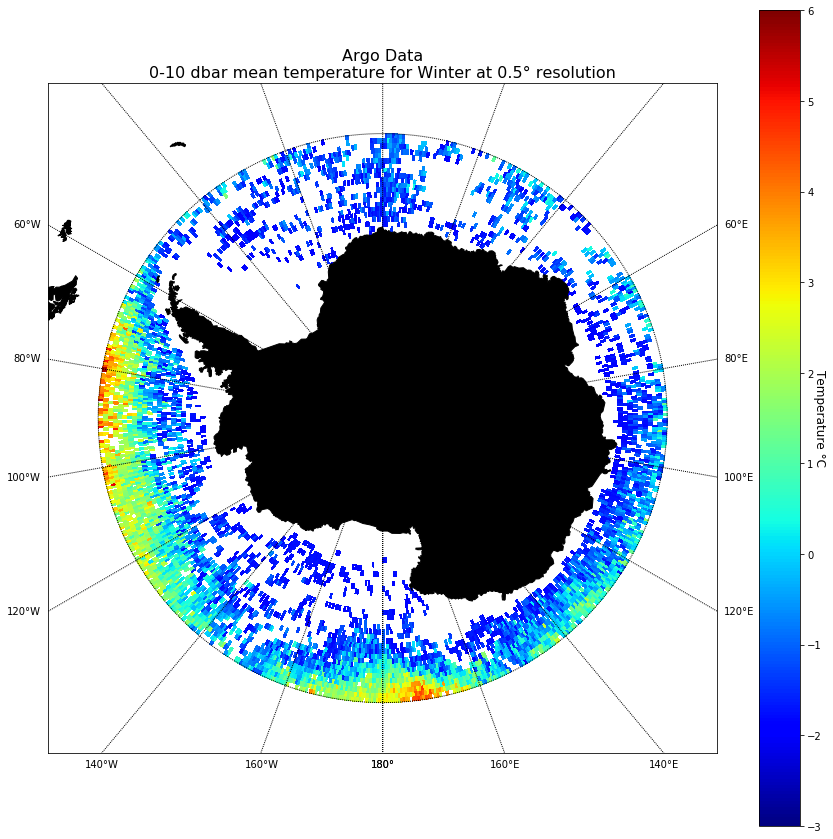

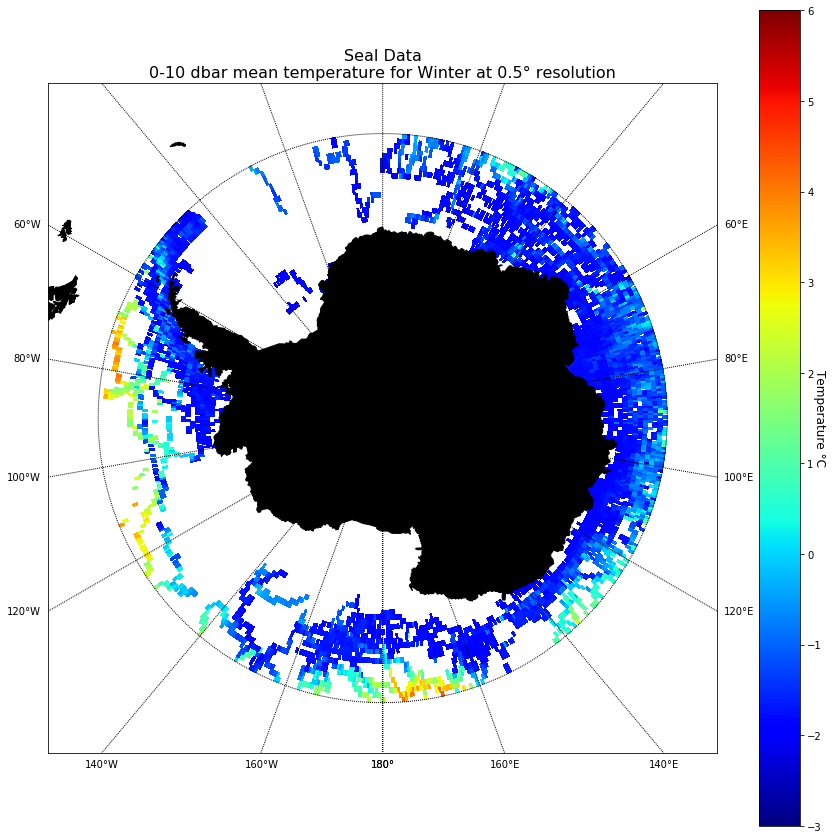

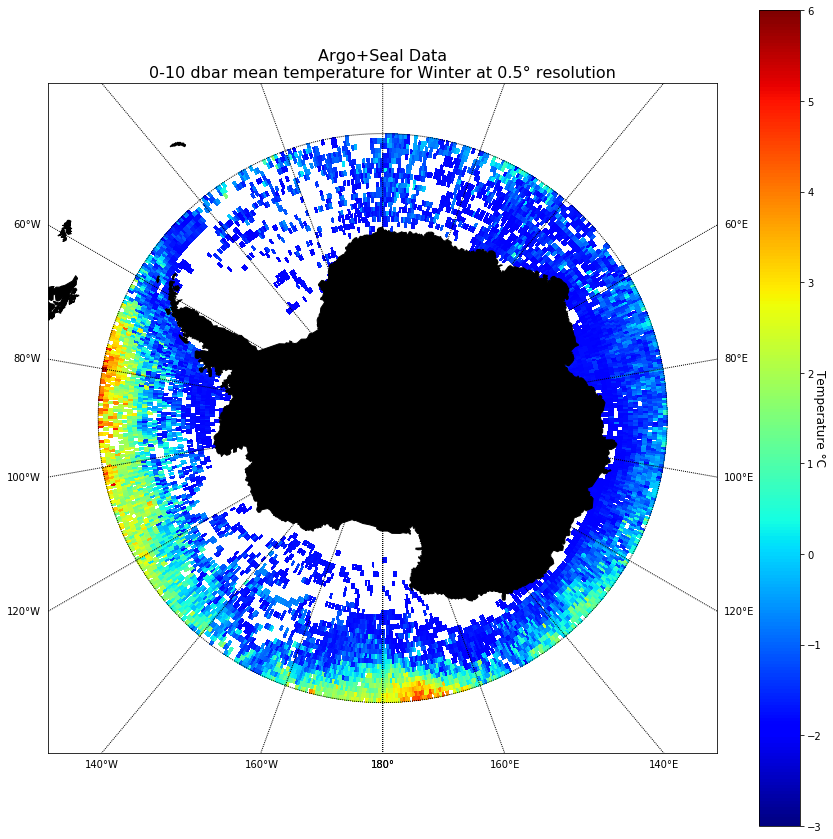

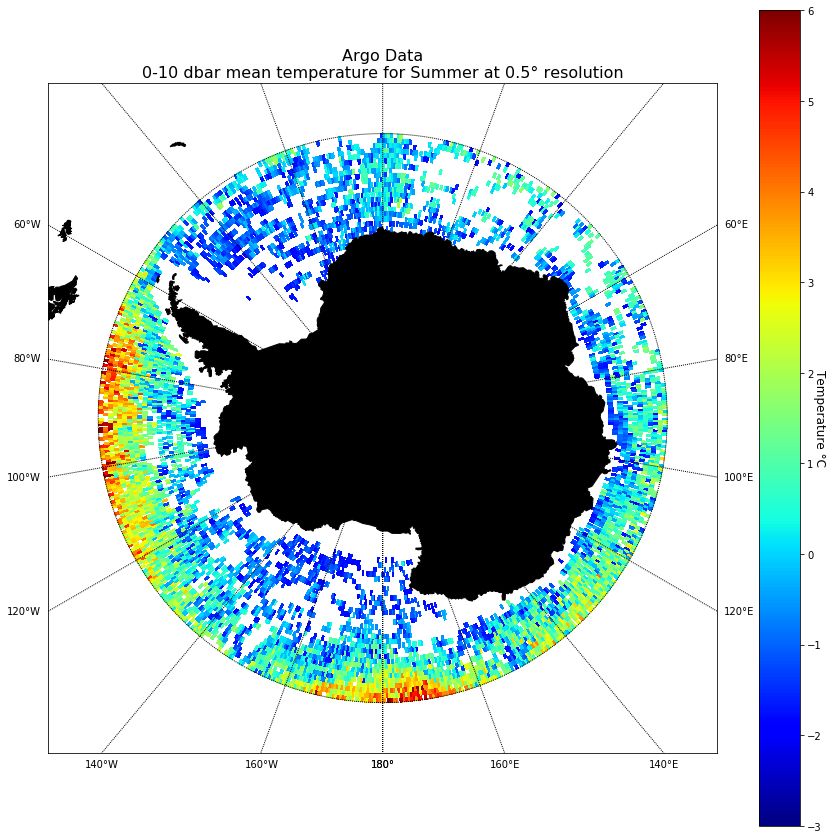

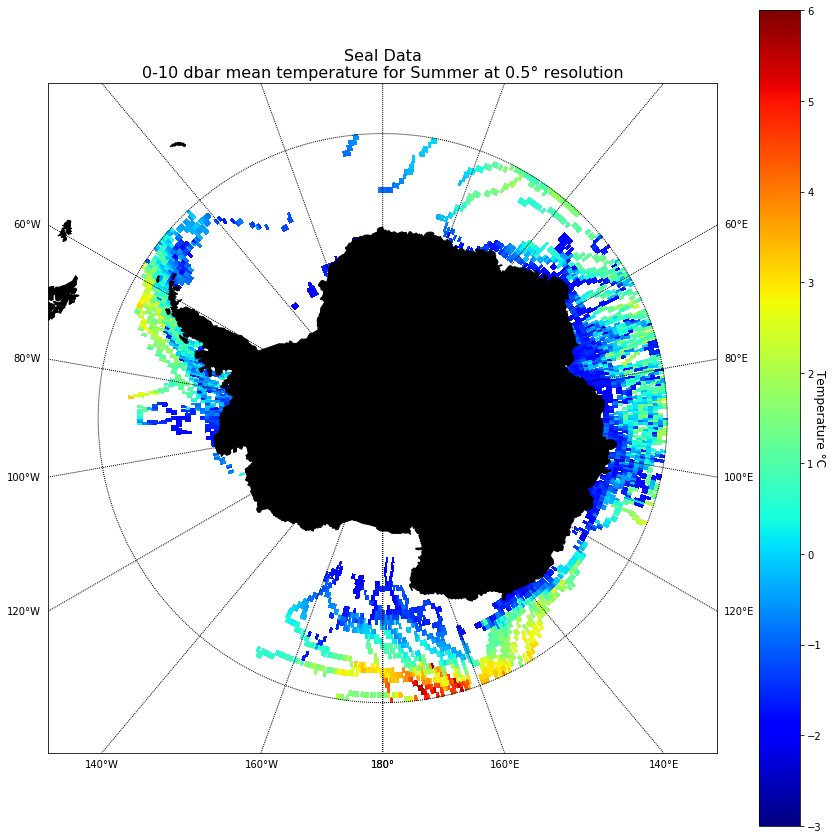

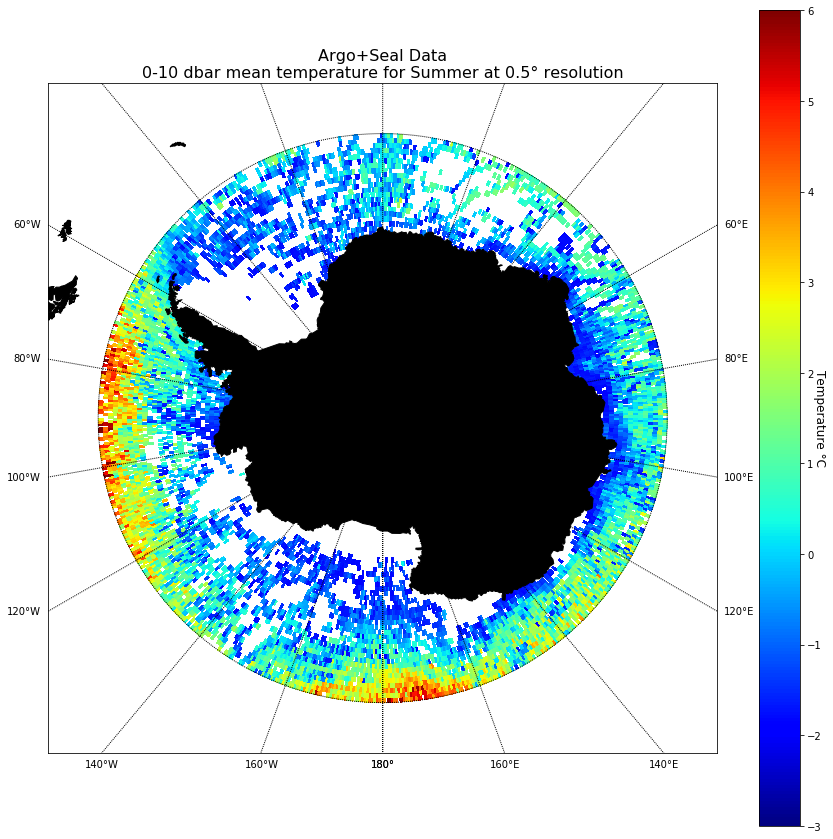

In [21]:
# Seasonal Temperature Filed

#dbars = [0, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 175, 190, 199]
dbars = [0]
#for db in dbars:
#    dbs = "{}-{} dbar ".format(db*10, (db+1)*10)
for season in ["Winter", "Summer"]:
    argo_temp = load_netcdf_grid(filter_season = season, with_depth=True, resolution = resolution)
    seal_temp = load_netcdf_grid("seal", filter_season = season, with_depth=True, resolution = resolution)
    combined_temp = np.nanmean((argo_temp, seal_temp), axis=0)
    np.save("argo_temp_{}".format(season), argo_temp)
    np.save("seal_temp_{}".format(season), seal_temp)
    np.save("combined_temp_{}".format(season), combined_temp)
    interp_temp = interp_nans(combined_temp[:,:,0])
#    argomean = np.round(np.nanmean(argo_temp), 2)
#    sealmean = np.round(np.nanmean(seal_temp), 2)
#    combmean = np.round(np.nanmean(combined_temp), 2)
#    interpmean = np.round(np.nanmean(interp_temp), 2)
    for db in dbars:
        dbs = "{}-{} dbar ".format(db*10, (db+1)*10)
        title = a_title + "\n" + dbs + mtf + "for {}".format(season)
        plot_grid(argo_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)
        #title = "Argo data 0-10 decibar mean temperature for {}\nMean across all points = {}".format(season, argomean)
        title = s_title + "\n" + dbs + mtf + "for {}".format(season)
        plot_grid(seal_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)
        title = comb_title + "\n" + dbs + mtf + "for {}".format(season)
        plot_grid(combined_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)

No salinity for data/Argo_South_60\DataSelection_20190704_211741_8047855\argo-profiles-5903716.nc
No salinity for data/Argo_South_60\DataSelection_20190704_211741_8047855\argo-profiles-7900325.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-1901251.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903315.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903716.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903818.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-7900326.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-1901251.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-1901277.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-2902737.nc
No salinity for data

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


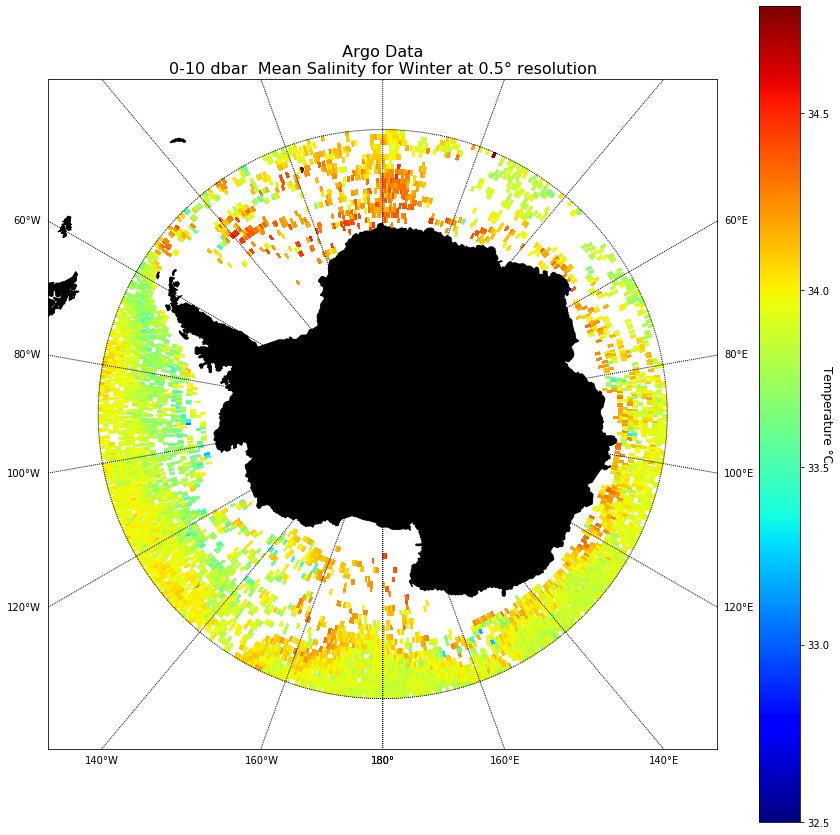

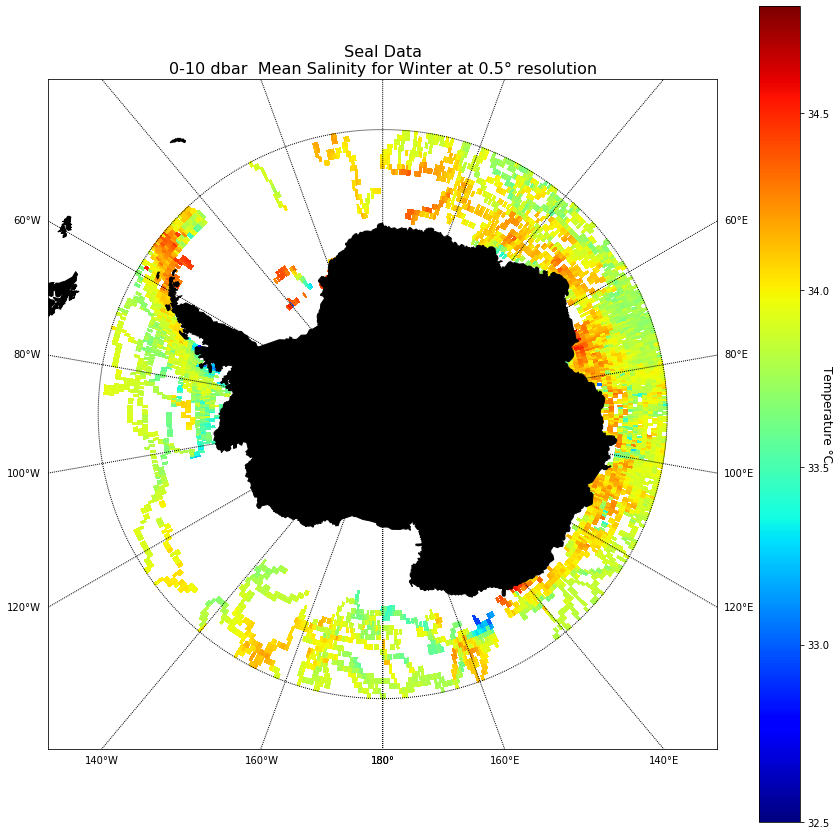

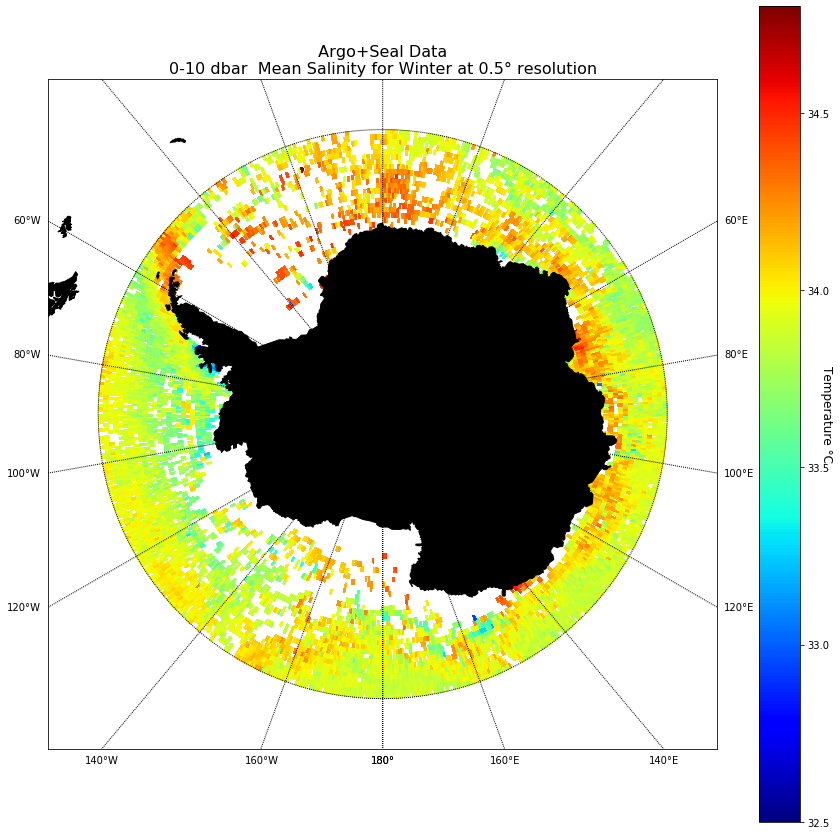

No salinity for data/Argo_South_60\DataSelection_20190704_211741_8047855\argo-profiles-5903716.nc
No salinity for data/Argo_South_60\DataSelection_20190704_211741_8047855\argo-profiles-7900325.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-1901251.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903315.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903716.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903818.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-7900326.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-1901251.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-1901277.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-2902737.nc
No salinity for data

In [ ]:
# Seasonal Salinity Field - 
#dbars = [0, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 175, 190, 199]
dbars = [0]
dbs = "{}-{} dbar".format(db*10, (db+1)*10)
for season in ["Winter", "Summer"]:
    argo_sal = load_netcdf_grid(target_var = "sal", filter_season = season, with_depth=True, resolution = resolution)
    seal_sal = load_netcdf_grid("seal", target_var = "sal", filter_season = season, with_depth=True, resolution = resolution)
    combined_sal = np.nanmean((argo_sal, seal_sal), axis=0)
    np.save("argo_sal_{}".format(season), argo_sal)
    np.save("seal_sal_{}".format(season), seal_sal)
    np.save("combined_sal_{}".format(season), combined_sal)
    interp_sal = interp_nans(combined_sal[:,:,0])
#    argo_sal_mean = np.round(np.nanmean(argo_sal), 2)
#    seal_sal_mean = np.round(np.nanmean(seal_sal), 2)
#    comb_sal_mean = np.round(np.nanmean(combined_sal), 2)
#    interpmean = np.round(np.nanmean(interp_sal), 2)
    #title = "Argo data 0-10 decibar mean temperature for {}\nMean across all points = {}".format(season, argo_temp_mean)
    # salinity plot
    title = a_title + "\n" + dbs + msf + "for {}".format(season)
    plot_grid(argo_sal[:,:,0], title=title, resolution = resolution, vmin=smin, vmax=smax)
    title = s_title + "\n" + dbs + msf + "for {}".format(season)
    plot_grid(seal_sal[:,:,0], title=title, resolution = resolution, vmin=smin, vmax=smax)
    title = comb_title + "\n" + dbs + msf + "for {}".format(season)
    plot_grid(combined_sal[:,:,0], title=title, resolution = resolution, vmin=smin, vmax=smax)

In [ ]:
print(argo_temp.shape, seal_temp.shape, combined_temp.shape)
#print(max(argo_temp[:,:,0]))
print(argo_lats.shape, argo_lons.shape)
print(seal_lats.shape, seal_lons.shape)
print(argo_lats)

In [31]:
resolution = 2
try:
    argo_temp_grid_withdepth = np.load("argo_temp_grid_withdepth.npy")
    seal_temp_grid_withdepth = np.load("seal_temp_grid_withdepth.npy")
    combined_temp_grid_withdepth = np.load("combined_temp_grid_withdepth.npy")
except:
    argo_temp_grid_withdepth = load_netcdf_grid(with_depth=True, resolution = resolution)
    seal_temp_grid_withdepth = load_netcdf_grid("seal", with_depth=True, resolution = resolution)
    combined_temp_grid_withdepth = np.nanmean((argo_temp_grid_withdepth, seal_temp_grid_withdepth), axis=0)
    np.save("argo_temp_grid_withdepth", argo_temp_grid_withdepth)
    np.save("seal_temp_grid_withdepth", seal_temp_grid_withdepth)
    np.save("combined_temp_grid_withdepth", combined_temp_grid_withdepth)
    

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [32]:
resolution = 2
try:
    argo_sal_grid_withdepth = np.load("argo_sal_grid_withdepth.npy")
    seal_sal_grid_withdepth = np.load("seal_sal_grid_withdepth.npy")
    combined_sal_grid_withdepth = np.load("combined_sal_grid_withdepth.npy")
except:
    argo_sal_grid_withdepth = load_netcdf_grid(target_var = "sal", with_depth=True, resolution = resolution)
    seal_sal_grid_withdepth = load_netcdf_grid("seal", target_var = "sal", with_depth=True, resolution = resolution)
    combined_sal_grid_withdepth = np.nanmean((argo_sal_grid_withdepth, seal_sal_grid_withdepth), axis=0)
    np.save("argo_sal_grid_withdepth", argo_sal_grid_withdepth)
    np.save("seal_sal_grid_withdepth", seal_sal_grid_withdepth)
    np.save("combined_sal_grid_withdepth", combined_sal_grid_withdepth)

No salinity for data/Argo_South_60\DataSelection_20190704_211741_8047855\argo-profiles-5903716.nc
No salinity for data/Argo_South_60\DataSelection_20190704_211741_8047855\argo-profiles-7900325.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-1901251.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903315.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903716.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-5903818.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212441_8047938\argo-profiles-7900326.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-1901251.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-1901277.nc
No salinity for data/Argo_South_60\DataSelection_20190704_212749_8048009\argo-profiles-2902737.nc
No salinity for data

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [ ]:
print(argo_temp_grid_withdepth.shape, seal_temp_grid_withdepth.shape, combined_temp_grid_withdepth.shape)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


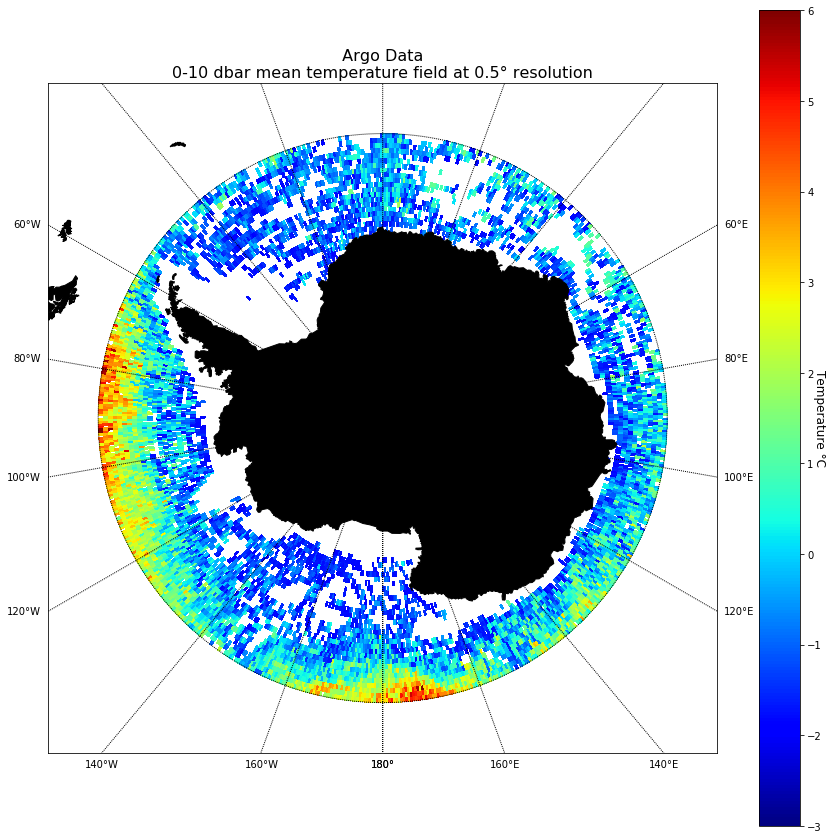

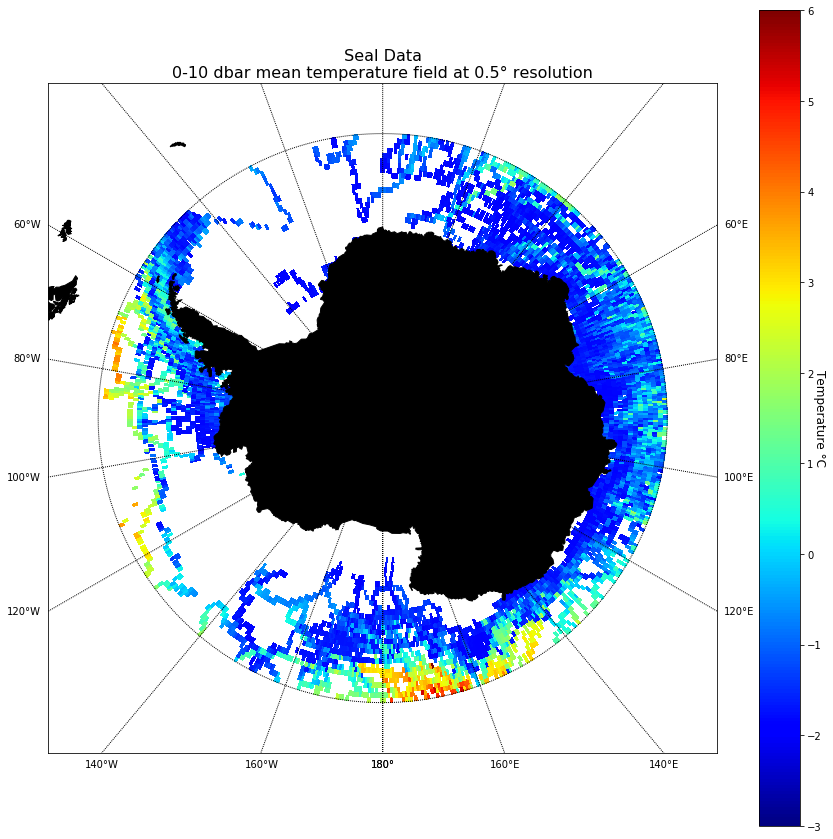

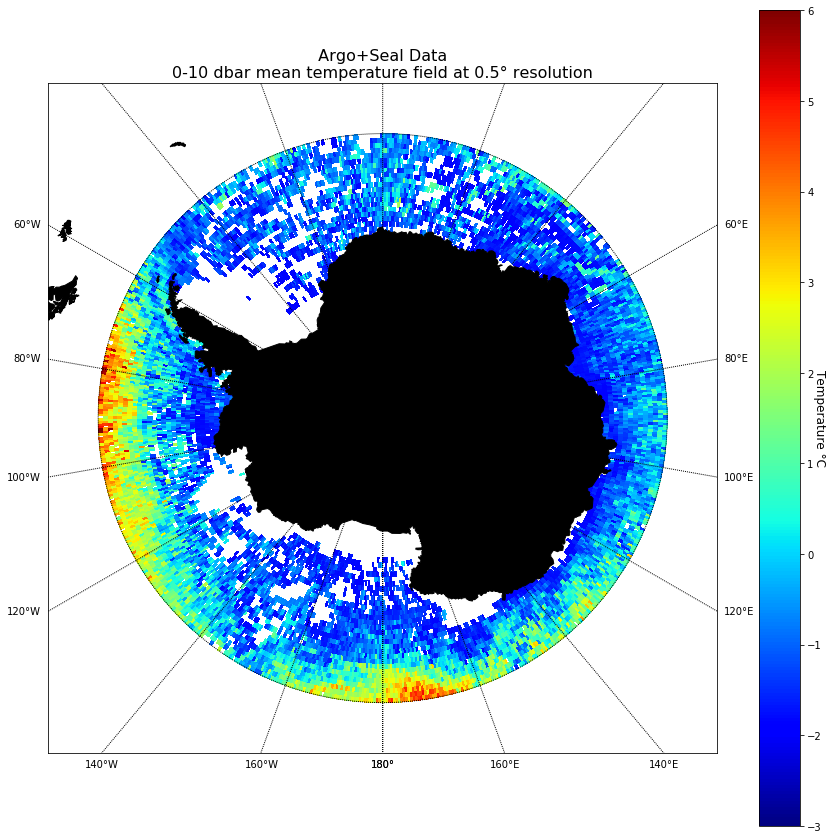

In [33]:
# Climatological Temperature Field

#dbars = [0, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 175, 190, 199]
dbars = [0]
for db in dbars:
    #Argo data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    dbs = "{}-{} dbar ".format(db*10, (db+1)*10)
#   dbs = "between {}-{} dbar".format(db*10, (db+1)*10)
    plot_grid(argo_temp_grid_withdepth[:,:,db], title=a_title + "\n" + dbs + mtf, resolution=resolution, vmin=tmin, vmax=tmax)
    plot_grid(seal_temp_grid_withdepth[:,:,db], title=s_title + "\n" + dbs + mtf, resolution=resolution, vmin=tmin, vmax=tmax)
    plot_grid(combined_temp_grid_withdepth[:,:,db], title=comb_title + "\n" + dbs + mtf, resolution=resolution, vmin=tmin, vmax=tmax)
    interp = interp_nans(combined_temp_grid_withdepth[:,:,db])
#    plot_grid(interp, title=interp_title + "\n" + dbs + mtf, resolution=resolution, vmin=vmin, vmax=vmax)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


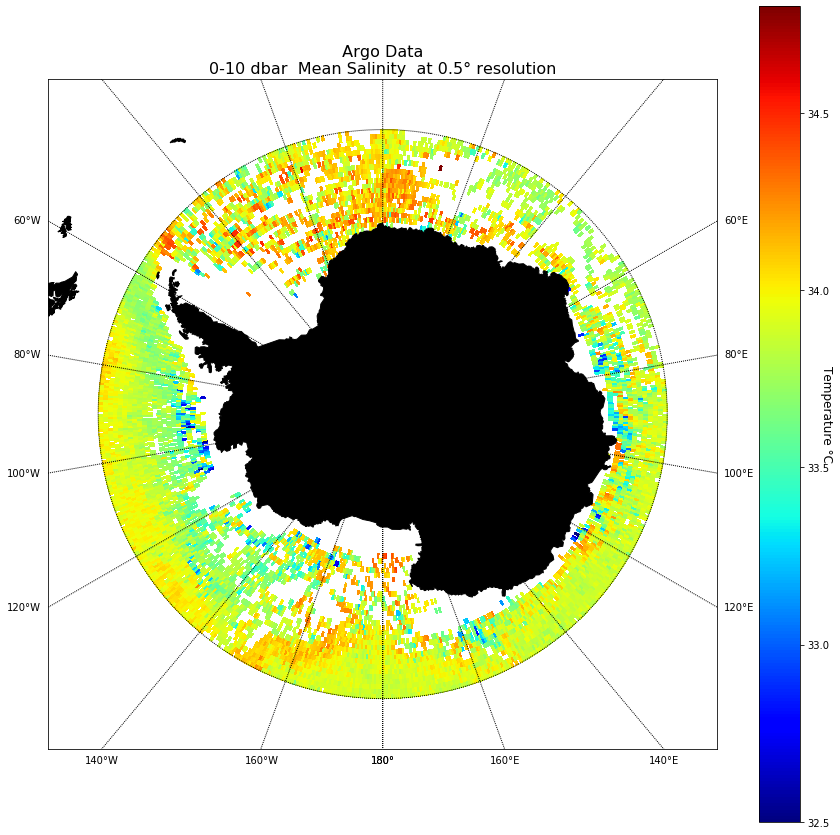

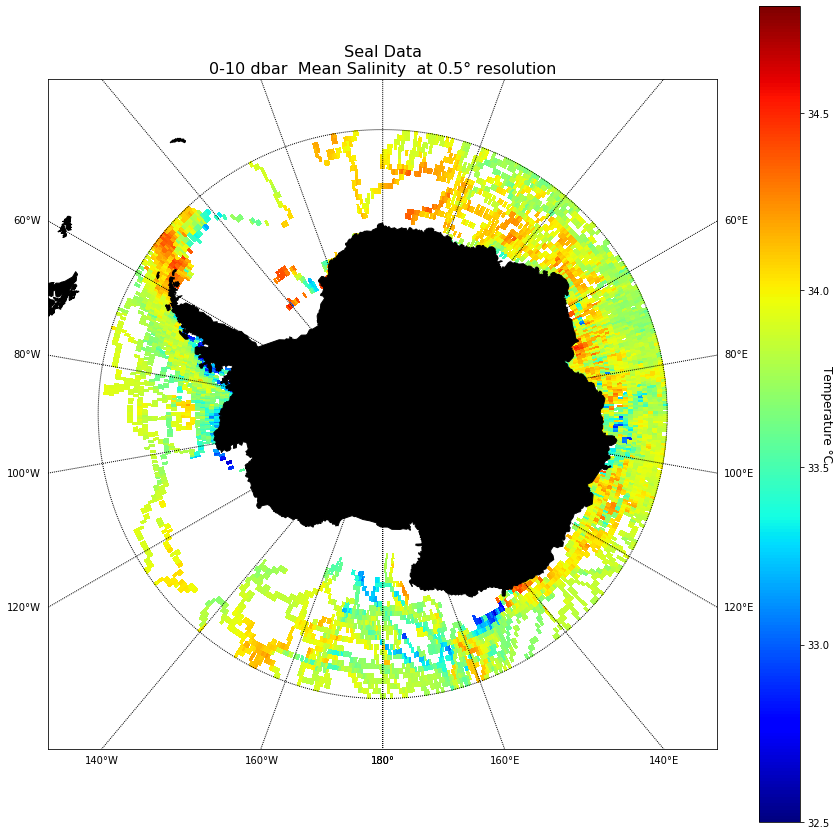

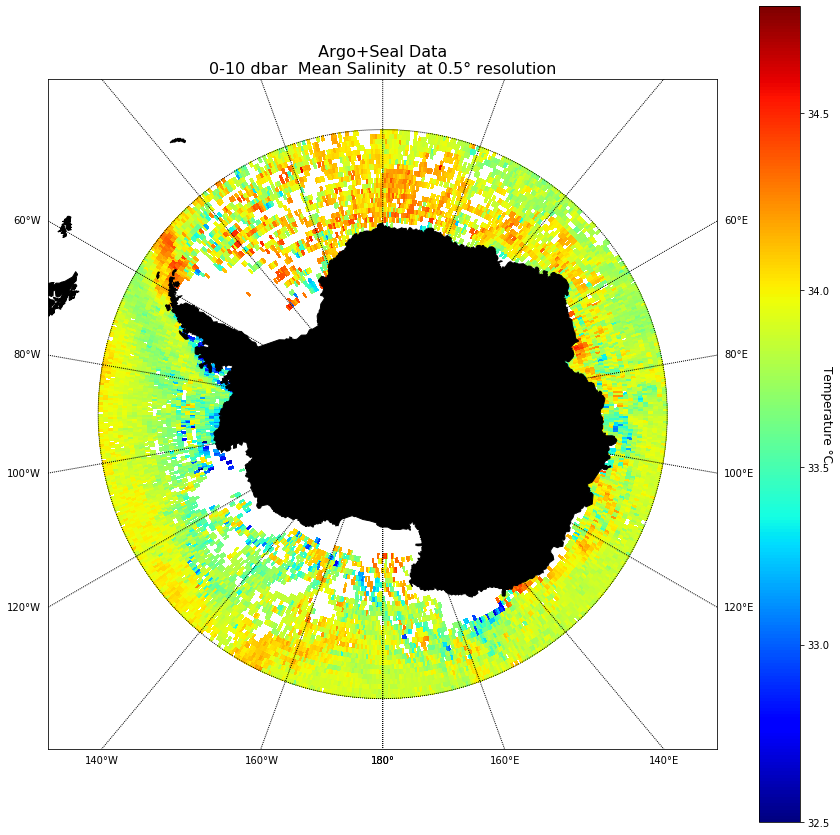

In [34]:
# Climatological Salinity Field

#dbars = [0, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 175, 190, 199]
dbars = [0]
for db in dbars:
    #Argo data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    dbs = "{}-{} dbar".format(db*10, (db+1)*10)
#   dbs = "between {}-{} dbar".format(db*10, (db+1)*10)
    plot_grid(argo_sal_grid_withdepth[:,:,db], title=a_title + "\n" + dbs + msf, resolution=resolution, vmin=smin, vmax=smax)
    plot_grid(seal_sal_grid_withdepth[:,:,db], title=s_title + "\n" + dbs + msf, resolution=resolution, vmin=smin, vmax=smax)
    plot_grid(combined_sal_grid_withdepth[:,:,db], title=comb_title + "\n" + dbs + msf, resolution=resolution, vmin=smin, vmax=smax)
    interp = interp_nans(combined_temp_grid_withdepth[:,:,db])
#    plot_grid(interp, title=interp_title + "\n" + dbs + mtf, resolution=resolution, vmin=vmin, vmax=vmax)

In [ ]:
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
#m.drawcoastlines()
#m.fillcontinents(color='black',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-60, 0, 20))
m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
#m.drawmapboundary(fill_color='aqua')
m.etopo()
plt.title("Bathymetry south of -60S")

In [ ]:
def plot_cross_slope(grid, title="Temperature at 179° W", lon=-179, cbtitle="Temperature °C", resolution = 1):
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    y = np.arange(-60, -75, -1/resolution)
    z = np.arange(0, 2000, 10)
    levels = np.arange(np.nanmin(grid), np.nanmax(grid), .01)
    im = ax.contourf(y, z, grid.T, cmap="jet", levels = levels, extend="both")
    ax.set_xlabel("° Latitude")
    ax.set_ylabel("Depth (dbar)")
    ax.set_title("{} at {} resolution".format(title, 1 / resolution))
    cb = fig.colorbar(im)
    cb.set_label(cbtitle, rotation=270)
    
    db = oceansdb.ETOPO()
    y = np.arange(-60, -75, -.01)
    h = -db['topography'].extract(lat=y, lon=lon)["height"]
    #ax.plot(y, h)
    ax.fill_between(y, 5000, h, color='black')
    ax.set_ylim(2000, 0)
    ax.set_xlim(-60, -74.5)
    
    plt.show()

filtered = combined_temp_grid_withdepth[:,2,:]
interp = interp_nans(filtered)
plot_cross_slope(filtered, resolution = resolution)
plot_cross_slope(interp, title="Interpolated Temperature at 179° W", resolution = resolution)

(30, 720, 200)
[]


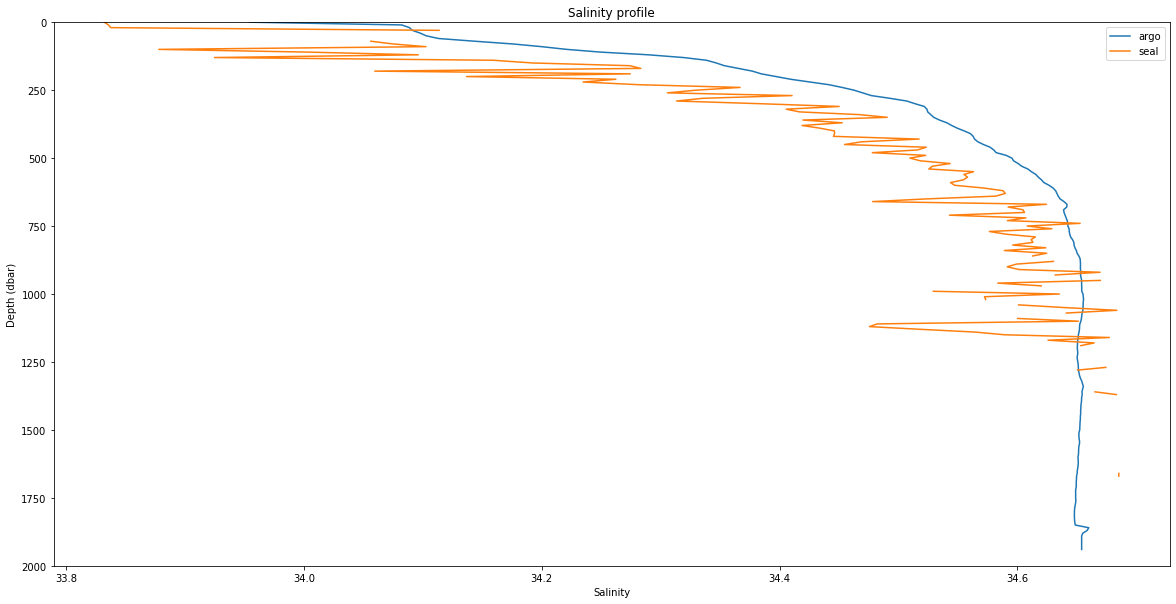

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
print(argo_sal_grid_withdepth.shape)
seal_counts = np.sum(~np.isnan(seal_sal_grid_withdepth), axis=2)
argo_counts = np.sum(~np.isnan(argo_sal_grid_withdepth), axis=2)
print(np.argwhere(seal_counts + argo_counts == 319))
depth = np.arange(0, 2000, 10)
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_title("Salinity profile")
ax.set_ylim(2000, 0)
ax.plot(argo_sal_grid_withdepth[11, 466, :], depth)
ax.plot(seal_sal_grid_withdepth[11, 466, :], depth)
ax.legend(["argo", "seal"])

(30, 720, 200)


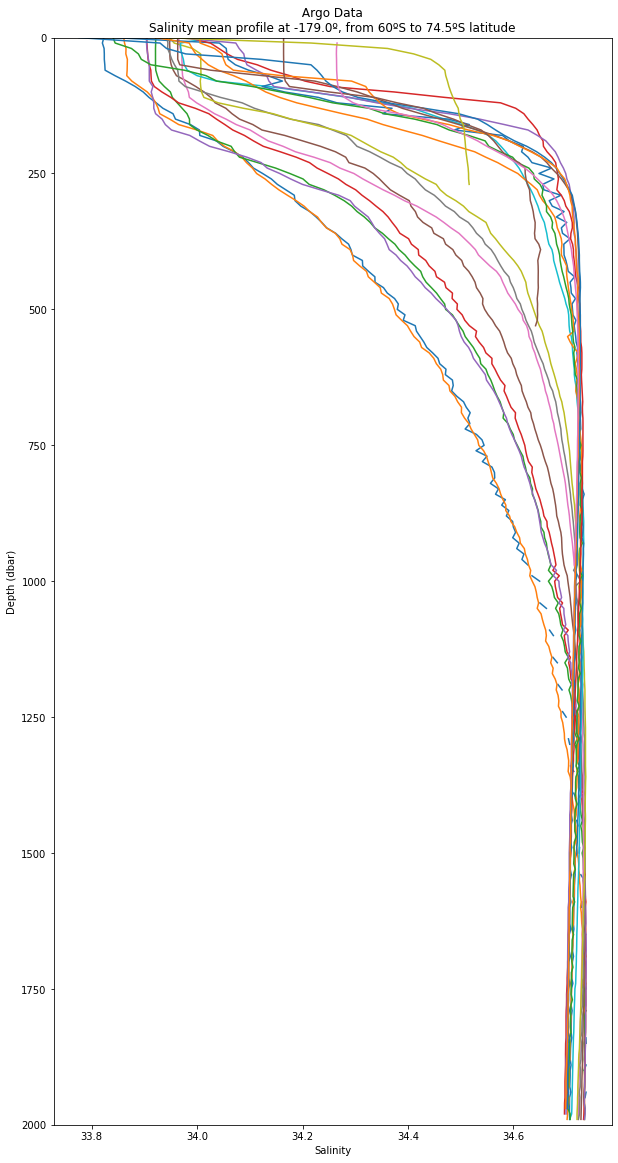

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,20))
print(argo_sal_grid_withdepth.shape)
depth = np.arange(0, 2000, 10)
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_ylim(2000, 0)
long = 2
long_label = (long/2)-180
lat_ini = "60ºS"
lat_end = "74.5ºS"
ax.set_title(a_title + "\nSalinity mean profile at {}º, from {} to {} latitude".format(long_label,lat_ini,lat_end))
for dim_lat in range(0,29):
    ax.plot(argo_sal_grid_withdepth[dim_lat, long, :], depth)
    #ax.legend(["argo[dim_lat]"])
#ax.plot(seal_sal_grid_withdepth[4, 715, :], depth)
#ax.legend(["argo", "seal"])
#print(argo_lats)
#print(argo_lats.shape)
#print(argo_lons.shape)

In [39]:
argo_temp_grid_withdepth_summer = np.load("argo_temp_Summer.npy")
argo_temp_grid_withdepth_winter = np.load("argo_temp_Winter.npy")
seal_temp_grid_withdepth_summmer = np.load("seal_temp_Summer.npy")
seal_temp_grid_withdepth_winter = np.load("seal_temp_Winter.npy")
combined_temp_grid_withdepth_summer = np.load("combined_temp_Summer.npy")
combined_temp_grid_withdepth_winter = np.load("combined_temp_Winter.npy")
    
argo_sal_grid_withdepth_summer = np.load("argo_sal_Summer.npy")
argo_sal_grid_withdepth_winter = np.load("argo_sal_Winter.npy")
seal_sal_grid_withdepth_summer = np.load("seal_sal_Summer.npy")
seal_sal_grid_withdepth_winter = np.load("seal_sal_Winter.npy")
combined_grid_withdepth_sal_summer = np.load("combined_sal_Summer.npy")
combined_sal_grid_withdepth_winter = np.load("combined_sal_Winter.npy")

In [ ]:
def season_profiles_plot(axs):
#    combined_sal_grid_withdepth = np.load("combined_sal_grid_withdepth.npy")
    box = dict(facecolor='none', pad=5, alpha=0.2)
    ssmax = 34.8
    ssmin=33.
    ttmax=3
    ttmin=-1
    # Fixing random state for reproducibility
    ax1 = axs[0, 0]
    #ax1.plot(argo_sal_grid_withdepth[5, 719, :], depth)
    ax1.plot(argo_temp_grid_withdepth_summer[5, 719, :], depth)
    ax1.plot(seal_temp_grid_withdepth_summmer[5, 719, :], depth)
    #ax1.plot(2000*np.random.rand(10))
    ax1.set_ylabel("Depth (dbar)")
    ax1.set_xlabel("Temperature")
    ax1.set_title('Summer')
    #ax1.set_ylabel('Salinity', bbox=box)
    ax1.set_xlim(ttmin, ttmax)
    ax1.set_ylim(2000, 0)
    ax1.legend(["argo", "seal"])

    ax3 = axs[1, 0]
    ax3.set_ylabel("Depth (dbar)")
    ax3.plot(argo_sal_grid_withdepth_summer[5, 719, :], depth)
    ax3.plot(seal_sal_grid_withdepth_summer[5, 719, :], depth)
    ax3.set_ylim(2000, 0)
    ax3.set_xlim(ssmin, ssmax)
    ax3.set_xlabel("Salinity")
    ax3.legend(["argo", "seal"])
    
    ax2 = axs[0, 1]
    ax2.set_title('Winter')
    ax2.plot(argo_temp_grid_withdepth_winter[2, 1, :], depth)
    ax2.plot(seal_temp_grid_withdepth_winter[2, 1, :], depth)
    ax2.set_ylabel("Depth (dbar)")
    ax2.set_xlabel("Temperature")
    ax2.set_ylim(2000, 0)
    ax2.set_xlim(ttmin, ttmax)
    ax2.legend(["argo", "seal"])

    ax4 = axs[1, 1]
    ax4.plot(argo_sal_grid_withdepth_winter[10, 220, :], depth)
    ax4.plot(seal_sal_grid_withdepth_winter[10, 220, :], depth)
    ax4.set_ylabel("Depth (dbar)")
    ax4.set_xlabel("Salinity")
    ax4.set_xlim(ssmin, ssmax)
    ax4.set_ylim(2000, 0)
    ax2.legend(["argo", "seal"])

# Plot 1:
#fig, ax = plt.subplots(1, 1, figsize=(10,20))
fig, axs = plt.subplots(2, 2, figsize=(5,10), sharey='row')
fig.subplots_adjust(left=0.01, wspace=0.4, bottom=0.01, hspace=0.2)
season_profiles_plot(axs)

# just align the last column of axes:
fig.align_ylabels(axs[:, 1])
plt.show()

In [74]:
for season in ["Summer", "Winter"]:
    argo_temp = np.load("argo_sal_{}.npy".format(season))
    seal_temp = np.load("seal_sal_{}.npy".format(season))
    fig, ax = plt.subplots(1, 1, figsize=(10,20))
    depth = np.arange(0, 2000, 10)
    ax.set_xlabel("{} temperature °C".format(season))
    ax.set_ylabel("Depth (dbar)")
    ax.set_title("{} temperature °C profile".format(season))
    ax.set_ylim(2000, 0)
    ax.plot(argo_temp[6, 233, :], depth)
    ax.plot(seal_temp[6, 233, :], depth)
    ax.legend(["argo", "seal"])
    print(argo_temp[8,238])

MemoryError: 

In [73]:
def dens_smow(T):
    '''
    Function calculates density of standard mean ocean water (pure water) using EOS 1980.
    INPUT: T = temperature [degree C (ITS-90)]
    OUTPUT: dens = density [kg/m^3]
    '''
    a0 = 999.842594;a1 = 6.793952e-2;a2 = -9.095290e-3;a3 = 1.001685e-4;a4 = -1.120083e-6;a5 = 6.536332e-9
    T68 = T * 1.00024
    dens = (a0 + (a1 + (a2 + (a3 + (a4 + a5*T68)*T68)*T68)*T68)*T68)
    return dens

def dens0(S, T):
    '''
    Function calculates density of sea water at atmospheric pressure
    USAGE:  dens0 = dens0(S,T)
    DESCRIPTION:
        Density of Sea Water at atmospheric pressure using
        UNESCO 1983 (EOS 1980) polynomial.
    INPUT:  (all must have same dimensions)
        S = salinity    [psu      (PSS-78)]
        T = temperature [degree C (ITS-90)]
    OUTPUT:
        dens0 = density  [kg/m^3] of salt water with properties S,T,
        P=0 (0 db gauge pressure)
    '''
    assert S.shape == T.shape
    T68 = T * 1.00024
    # UNESCO 1983 eqn(13) p17.
    b0 = 8.24493e-1;b1 = -4.0899e-3;b2 = 7.6438e-5;b3 = -8.2467e-7;b4 = 5.3875e-9
    c0 = -5.72466e-3;c1 = +1.0227e-4;c2 = -1.6546e-6
    d0 = 4.8314e-4
    dens = (dens_smow(T) + (b0+ (b1+(b2+(b3+b4*T68)*T68)*T68)*T68)*S + (c0+(c1+c2*T68)*T68)*S*np.sqrt(S)+ d0*(S**2) )
    return dens

In [ ]:
#Cell added on 21/10/2019 - still testing
# adding function for TS Diagram
dens = dens0(argo_sal_grid_withdepth, argo_temp_grid_withdepth)
# print(combined_temp_grid_withdepth[0])
#shape of dens - (30,720,200) = (latitude, longitude, vertical layers)

cmap = plt.get_cmap('jet_r');cmap.set_bad(color='white')

fig = plt.figure(4,figsize=(15,15))  #TS-diagram of Argo profiles in the Ross Sea Slice
plt.scatter(argo_sal_grid_withdepth[0:10],argo_temp_grid_withdepth[0:10],s = 2,c=dens[0:10],cmap = cmap, edgecolors='none',alpha=0.8)
plt.xlim(33.8,35);plt.ylim(-2.5,5)
plt.clb = plt.colorbar();plt.clb.ax.set_title('Density (kg/m$^3$)')                  
#plt.xlabel('Pratical salinity',fontsize = 18);
#plt.ylabel('Temperature ($^oC$)',fontsize = 18)
ax.set_xlabel('Pratical salinity',fontsize = 18);
ax.set_ylabel('Temperature ($^oC$)',fontsize = 18)
plt.title('T-S diagram, Argo profiles',fontsize = 20)
# plt.axis('tight')
plt.show()
#     for i in range(0, len(FILES)):
#         read = Dataset(source + count_60[j][1] + '/profiles/' + FILES[i], mode = 'r')
#         Lat = read.variables['LATITUDE'][:]
#         Lon = read.variables['LONGITUDE'][:]
#         if Lon[0] < -140, Lon[0] > 160:
#             Temp = read.variables['TEMP'][:]
#             Psal = read.variables['PSAL'][:]
#             sigma = dens0(Psal[0],Temp[0])
#             scatter(Psal[0],Temp[0],s = 2,c=sigma,cmap = cmap, edgecolors='none',alpha=0.8)

# xlim(33.8,35);ylim(-2.5,5)
# clb = colorbar()#;clb.ax.set_title('Density (kg/m$^3$)')                  
# axis('tight');grid('on',alpha=0.2)
# # savepath = os.path.join('C:/Users/fvie285/Desktop/PhD_Project/Data/figures/Argo_South_of_50/aoml_figures/TS_diagram_RSS.png')
# # savefig(savepath, bbox_inches='tight', dpi=300) 
# show()


In [ ]:
dens = dens0(combined_sal_grid_withdepth, combined_temp_grid_withdepth)
dbars = [30, 50, 100]
for db in dbars:
    dbs = "from {}-{} dbar".format(db*10, (db+1)*10)
    plot_grid(dens[:,:,db], title=comb_title + "\n" + dbs + msd, resolution=resolution, vmin=rhomin, vmax=rhomax)
    interp = interp_nans(dens[:,:,db])
    print(np.nanmin(interp), np.nanmax(interp))
    plot_grid(interp, title="Interpolated gridded seal+argo density data " + dbs, cbtitle="Density", resolution=resolution, vmin=rhomin, vmax=rhomax)

In [ ]:
plot_cross_slope(dens[:,2,:], title="Density at 179° W", cbtitle="Density", resolution=resolution)
plot_cross_slope(interp_nans(dens[:,2,:]), title="Interpolated density at 179° W", cbtitle="Density", resolution=resolution)